In [1]:
import numpy as np
import torch
import math
from scipy.spatial.transform import Rotation as R
import meshplot as mp # useful for visualizing
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import trimesh

from fabhacks_min import *
from fabhacks_min.parts.part import Part

import igl


In [17]:
# Loading a mesh and do uniformly samplings on the surface

# This is just a manual example of how we load reduced original and reduced mesh. 
original_mesh_path = 'step2/original_mesh/cloth_hanger2.obj'
reduced_mesh_path = 'step2/reduced_mesh/segmentedRod.obj'
original_mesh = trimesh.load_mesh(original_mesh_path)
reduced_mesh = trimesh.load_mesh(reduced_mesh_path)
original_part_instance = Part()
# example usage:   V, F = igl.read_triangle_mesh(mesh_path)
# For my understanding, we only need to get the original_mesh's center? 
# Then we simply move on to run parametrization on the reduced mesh?
V1, F1 = igl.read_triangle_mesh(original_mesh_path)
original_part_instance.compute_com(V1, F1)
original_com_offset = original_part_instance.com_offset # I assume this is the center of the original mesh?
print(type(original_com_offset))

# Idea: 
# find the original mesh and reduced mesh, in particular we get the V and F form
# use the part.py function to calculate the center 

# Sample points uniformly from the surface of the mesh
original_points, _ = trimesh.sample.sample_surface_even(original_mesh, 1000)
original_points_numpy = np.array(original_points)
plot = mp.plot(original_points_numpy, shading={'point_size': 5})


points, _ = trimesh.sample.sample_surface_even(reduced_mesh, 1000)  # sample normally? 
points_numpy = np.array(points)
points_tensor = torch.tensor(points_numpy, dtype=torch.float32)

plot.add_points(points_numpy, shading={'point_size':5, 'point_color':'green'}) # Mingshegn(my(input))



<class 'numpy.ndarray'>


  o obj_0


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.7265625…

1

In [24]:
# Parameters:
# center (x,y,z), axis (a_x, a_y, a_z), radius
# surface parameterization: u,v

# Equation:
# s(u,v) = C + radius * x_dir cos(u) + radius * y_dir sin(u) + axis * v

# Additionally: we impose assumptions that, x_axis, y_axis and z_axis are orthonormal to each other.


def cylinder(parameters):
    center = parameters[:3]
    axis = parameters[3:6]
    radius = parameters[6]
    length = parameters[7]
    z_dir = axis / torch.linalg.norm(axis) # so z_dir is normalized

    if torch.linalg.norm(z_dir - torch.tensor([1.,0,0])) < .000001:
        y_dir = torch.tensor([0,1.,0])
    else:
        y_dir = torch.cross(z_dir, torch.tensor([1.,0,0]), dim=-1)
    y_dir = y_dir / torch.norm(y_dir)
    x_dir = torch.cross(y_dir, z_dir, dim=-1)
    x_dir = x_dir / torch.norm(x_dir)

    print("x, y, z directions are: ", x_dir, y_dir, z_dir)
    # print(torch.dot(x_dir, y_dir), torch.dot(z_dir, y_dir), torch.dot(x_dir, z_dir)) # For validation checks
    # print(torch.norm(x_dir), torch.norm(y_dir), torch.norm(z_dir))

    x_original = torch.tensor([1., 0, 0])
    y_original = torch.tensor([0., 1, 0])
    z_original = torch.tensor([0., 0, 1])

    # This is already the rotation matrix!
    # It rotates the standard primitive in OpenSCAD to the learned optimal primitive
    R_total = torch.stack([x_dir.dot(x_original), y_dir.dot(x_original), z_dir.dot(x_original),
                        x_dir.dot(y_original), y_dir.dot(y_original), z_dir.dot(y_original),
                        x_dir.dot(z_original), y_dir.dot(z_original), z_dir.dot(z_original)]).reshape(3, 3)

    # Decompose R_total into rotation matrices using SVD
    U, _, V = torch.svd(R_total)
    R_x = U @ V.t()
    R_y = U @ V.t()
    R_z = U @ V.t()

    # Convert to Euler angles for each axis individually
    euler_x_rad = torch.atan2(R_x[2, 1], R_x[2, 2])
    euler_y_rad = torch.atan2(-R_x[2, 0], torch.sqrt(R_x[2, 1] ** 2 + R_x[2, 2] ** 2))
    euler_z_rad = torch.atan2(R_x[1, 0], R_x[0, 0])

    euler_x_deg = round(math.degrees(euler_x_rad.item()), 2)
    euler_y_deg = round(math.degrees(euler_y_rad.item()), 2)
    euler_z_deg = round(math.degrees(euler_z_rad.item()), 2)

    print("Euler angles:", euler_x_deg, euler_y_deg, euler_z_deg)

    translation = center[:3].detach().numpy() - original_com_offset # subtracting our parametrization by the center of the original mesh
    print("Center of the original mesh: ", original_com_offset)
    print("Center of our learned primitive: ", center[:3])
    print("Translation: ", translation)
    
    random_coords = torch.rand(1000, 3)

    u = random_coords[:,0:1]
    v = random_coords[:,1:2]

    v = v * length - length / 2

    return center + radius * x_dir * torch.cos(2*torch.pi*u) + radius * y_dir * torch.sin(2*torch.pi*u) + axis * v, translation, torch.tensor([euler_x_deg, euler_y_deg, euler_z_deg])

# It returns a 3-valued tuple, the first element is the regular parameters, the two following ones are translation and rotation.  

In [25]:

init_parameters = torch.tensor([0.,0,0,1,0,0,10, 10])
cyl = cylinder(init_parameters)
points_cyl = cyl[0].numpy()
translation = cyl[1]
rotation = cyl[2]
print("Here is the returned values:")
print("Translation: ", translation)
print("Rotation: ", rotation)
mp.plot(points_cyl, shading={'point_size':2})

'''
init_parameters = torch.tensor([0.,0,0,0,0,6,10, 3])
points_cyl = torus(init_parameters).numpy()
mp.plot(points_cyl, shading={'point_size':2})
'''
'''
init_parameters = torch.tensor([0.,0,0,0,0,6,50, 30, 20])
points_cyl = rectangle(parameters=init_parameters).numpy()
mp.plot(points_cyl, shading={'point_size':2})
'''
'''
init_parameters = torch.tensor([0.,0,0,0,0,6,30])
points_cyl = hemisphere(parameters=init_parameters).numpy()
mp.plot(points_cyl, shading={'point_size':2})
'''

x, y, z directions are:  tensor([ 0.,  0., -1.]) tensor([0., 1., 0.]) tensor([1., 0., 0.])
Euler angles: 0.0 90.0 0.0
Center of the original mesh:  [  4.66084633 -25.50000042  28.6775397 ]
Center of our learned primitive:  tensor([0., 0., 0.])
Translation:  [ -4.66084633  25.50000042 -28.6775397 ]
Here is the returned values:
Translation:  [ -4.66084633  25.50000042 -28.6775397 ]
Rotation:  tensor([ 0., 90.,  0.])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0048542…

"\ninit_parameters = torch.tensor([0.,0,0,0,0,6,30])\npoints_cyl = hemisphere(parameters=init_parameters).numpy()\nmp.plot(points_cyl, shading={'point_size':2})\n"

  0%|          | 0/3000 [00:00<?, ?it/s]

x, y, z directions are:  tensor([ 0.4099,  0.3421, -0.8455], grad_fn=<DivBackward0>) tensor([-0.0000, 0.9270, 0.3750], grad_fn=<DivBackward0>) tensor([ 0.9121, -0.1537,  0.3800], grad_fn=<DivBackward0>)
Euler angles: 44.62 57.73 39.85
Center of the original mesh:  [  4.66084633 -25.50000042  28.6775397 ]
Center of our learned primitive:  tensor([-1.4568, -0.1320,  0.9187], grad_fn=<SliceBackward0>)
Translation:  [ -6.11763344  25.36796412 -27.75888526]
x, y, z directions are:  tensor([ 0.8152,  0.4092, -0.4099], grad_fn=<DivBackward0>) tensor([-0.0000, 0.7077, 0.7065], grad_fn=<DivBackward0>) tensor([ 0.5792, -0.5759,  0.5769], grad_fn=<DivBackward0>)
Euler angles: 50.77 24.2 26.66
Center of the original mesh:  [  4.66084633 -25.50000042  28.6775397 ]
Center of our learned primitive:  tensor([  98.5432, -100.1320,  100.9186], grad_fn=<SliceBackward0>)
Translation:  [ 93.88235893 -74.63202625  72.24110043]
x, y, z directions are:  tensor([ 0.8116,  0.4115, -0.4148], grad_fn=<DivBackward

<function matplotlib.pyplot.show(close=None, block=None)>

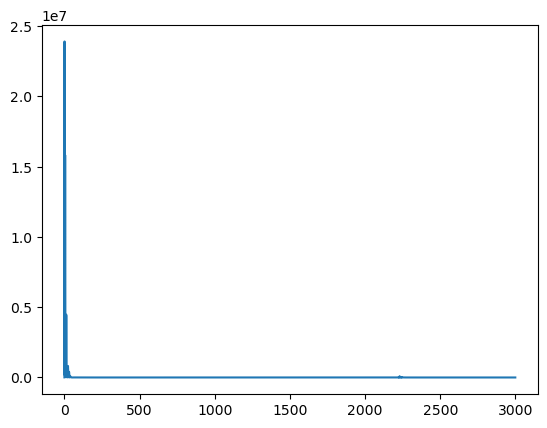

In [26]:
# diff. learning on a certain mesh input

import pytorch3d 
from pytorch3d.loss import chamfer_distance

# opt_parameters_init_stage = torch.tensor([0.,0,0, 1,1,1,1]) # an initial parameter close to the given param
# normal distribution
opt_params = torch.randn(8) # <==== ALSO change this line
opt_params.requires_grad = True

optimizer = torch.optim.Adam([opt_params], 100) # 100 is a good lr
losses = []

points_tensor = points_tensor.view(1, -1, 3) 

for _ in tqdm(range(3000)): # for the progress bar
    optimizer.zero_grad()
    opt_points, _, _ = cylinder(opt_params) # <==== THIS line is what should be changed for different primitive
    opt_points = opt_points.view(1, -1, 3)

    # loss = ((points - opt_points)**2).sum() # TODO: change to champfer loss | volume matrix sampling | closed meshes?
    loss = chamfer_distance(x = points_tensor, y = opt_points) # returns a 2-element tuple? I suppose the first element is what we want
    loss = loss[0]
    
    loss.backward()
    optimizer.step()
    losses.append(loss.detach().item())
plt.plot(losses)
plt.show

In [27]:
points_tensor = points_tensor.reshape(-1, 1, 3)
# plot = mp.plot(points.numpy(), return_plot=True, shading={'point_size':.5})
plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':5})

opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(opt_points.detach().numpy(), shading={'point_size':5, 'point_color':'green'})
print(opt_points.shape)
print(opt_params)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.7836456…

torch.Size([1000, 1, 3])
tensor([ 6.9351e+00, -2.5465e+01,  7.3830e+00, -5.0250e+01,  1.1622e-02,
        -1.1158e-01, -3.6076e+00,  6.0081e+00], requires_grad=True)


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt

def parameter(opt_points):
    # Assuming opt_points is a [N, 3] tensor
    opt_points_np = opt_points.detach().cpu().numpy().reshape(-1, 3)

    pca = PCA(n_components=3)
    pca.fit(opt_points_np)
    directions = pca.components_ 
    # print(directions)

    # find x-axis (assuming the longest component is x)
    x_axis_index = np.argmax(np.abs(directions[:, 0]))
    x_direction = directions[x_axis_index]  # x_axis_index is 0

    # calculate the center
    center = np.mean(opt_points_np, axis=0)

    # Project points onto the x_direction to find length and find the cylinder length
    projection_lengths = np.dot(opt_points_np - center, x_direction)
    min_proj, max_proj = np.min(projection_lengths), np.max(projection_lengths)
    cylinder_length = max_proj - min_proj

    # compute radius by considering the distance of points from the cylinder axis
    # project points onto the orthogonal plane
    orthogonal_projection = np.cross(opt_points_np - center, x_direction)
    radius = np.mean(np.linalg.norm(orthogonal_projection, axis=1))  # Mean radius
    return torch.tensor([center[0], center[1], center[2], 1, 0, 0, radius, cylinder_length], dtype=torch.float32)

# This opt_points is founder due to optimizing the cloud points above
# Which one should we use? What is the point of using ML to optimize the point cloud?
parameters = parameter(torch.clone(opt_points))
parameters2 = parameter(torch.clone(points_tensor))
print(parameters)
print(parameters2)


tensor([  6.3240, -25.4864,   7.5974,   1.0000,   0.0000,   0.0000,   3.4427,
        302.6579])
tensor([  4.4950, -25.4525,   7.5549,   1.0000,   0.0000,   0.0000,   3.7431,
        302.1064])


In [ ]:
print(parameters)
print(parameters2)

points = cylinder(parameters).numpy()
points2 = cylinder(parameters2).numpy()


# mp.plot(points, shading={'point_size':5})

plot = mp.plot(points_tensor.detach().numpy(), return_plot=True, shading={'point_size':5})

# points_tensor: original points 
# opt_points: the optimal cylinder learned from ML
# points: the cylinder from the parameters learned from Mingsheng's model applied on opt_points
# points2: the cylinder from the parameters learned from Mingsheng's model applied on points_tensor


# opt_points = opt_points.reshape(-1, 1, 3)
plot.add_points(points, shading={'point_size':5, 'point_color':'green'}) # Mingshegn(my(input))
plot.add_points(points2, shading={'point_size':5, 'point_color':'blue'}) # Mingsheng(input)


tensor([  6.3240, -25.4864,   7.5974,   1.0000,   0.0000,   0.0000,   3.4427,
        302.6579])
tensor([  4.4950, -25.4525,   7.5549,   1.0000,   0.0000,   0.0000,   3.7431,
        302.1064])


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.6134185…

2